In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
path = os.getcwd()

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7904047117345923774
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1075752197102207531
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


* 데이터셋

In [7]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


* Unet

In [8]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

# class Unet(tf.keras.Model): 
#     def __init__(self,): 
#         super(Unet, self).__init__()

#         self.enc1_1 = CBR2d(out_channels = 4) 
#         self.enc1_2 = CBR2d(out_channels=4)
            
#         self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
#         self.enc2_1 = CBR2d(out_channels=8)
#         self.enc2_2 = CBR2d(out_channels=8)
        
#         self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
#         self.enc3_1 = CBR2d(out_channels=12)
#         self.enc3_2 = CBR2d(out_channels=12)
#         self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )

#         self.enc4_1 = CBR2d(out_channels=16)
#         self.enc4_2 = CBR2d(out_channels=16)
#         self.pool4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
#         self.enc5_1 = CBR2d(out_channels=20)
#         self.dec5_1 = CBR2d(out_channels=16)

#         self.unpool4 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=2,strides=(2, 2))

#         self.dec4_2 = CBR2d(out_channels=16)
#         self.dec4_1 = CBR2d(out_channels=12)

#         self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=12, kernel_size=2,strides=(2, 2))

#         self.dec3_2 = CBR2d(out_channels=12)
#         self.dec3_1 = CBR2d(out_channels=8)

#         self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=2,strides=(2, 2))

#         self.dec2_2 = CBR2d(out_channels=8)
#         self.dec2_1 = CBR2d(out_channels=4)

#         self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=2,strides=(2, 2))

#         self.dec1_2 = CBR2d(out_channels=4)
#         self.dec1_1 = CBR2d(out_channels=4)

#         self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
#     def call(self, input): 
      
#         enc1_1 = self.enc1_1(input)
#         enc1_2 = self.enc1_2(enc1_1)
        
#         pool1 = self.pool1(enc1_2)

#         enc2_1 = self.enc2_1(pool1)
#         enc2_2 = self.enc2_2(enc2_1)
        
#         pool2= self.pool2(enc2_2)
  
#         enc3_1 = self.enc3_1(pool2)
#         enc3_2 = self.enc3_2(enc3_1)
        
#         pool3= self.pool3(enc3_2)

#         enc4_1 = self.enc4_1(pool3)
#         enc4_2 = self.enc4_2(enc4_1)
        
#         pool4= self.pool3(enc4_2)

#         enc5_1 = self.enc5_1(pool4)
        
#         dec5_1 = self.dec5_1(enc5_1)
        

#         unpool4 = self.unpool4(dec5_1)

#         cat4 = tf.keras.layers.Concatenate(axis=3)([unpool4, enc4_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        
#         dec4_2 = self.dec4_2(cat4)
#         dec4_1 = self.dec4_1(dec4_2)
       
#         unpool3 = self.unpool3(dec4_1)
    
#         cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
#         dec3_2 = self.dec3_2(cat3)
#         dec3_1 = self.dec3_1(dec3_2)
        
#         unpool2 = self.unpool2(dec3_1)
        
#         cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
#         dec2_2 = self.dec2_2(cat2)
#         dec2_1 = self.dec2_1(dec2_2)
        
#         unpool1 = self.unpool1(dec2_1)
        
#         cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
#         dec1_2 = self.dec1_2(cat1)
#         dec1_1 = self.dec1_1(dec1_2)
        
#         x = self.outlayer(dec1_1)
#         return x

class Unet(tf.keras.Model): 
    def __init__(self,): 
        super(Unet, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 4) 
        self.enc1_2 = CBR2d(out_channels=4)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=8)
        self.enc2_2 = CBR2d(out_channels=8)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc5_1 = CBR2d(out_channels=20)
        self.dec5_1 = CBR2d(out_channels=16)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=8)
        self.dec2_1 = CBR2d(out_channels=4)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=4)
        self.dec1_1 = CBR2d(out_channels=4)

        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
        
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        
        pool2= self.pool2(enc2_2)
  
        

        enc5_1 = self.enc5_1(pool2)
        
        dec5_1 = self.dec5_1(enc5_1)
        

       
        unpool2 = self.unpool2(dec5_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x





# x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
# y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

# batch_size = 20
# epoch = 1000
# buffer_len = len(x_train_tensor)
# n_run = np.ceil(len(x_train_tensor)/batch_size)

# train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
# shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

# net_1 = Unet()
# # test_net = Unet()
# # pred = test_net(x_train)

* 앙상블 학습

In [9]:
class tree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.weak_unet = None

        self.y_val = y_val
        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.kernel_cords = np.concatenate([ax1,ax2,ax3],axis = 1)


    def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        

        l_arr = np.float32(l_values)
        r_arr = np.float32(r_values)

        max_val = np.max(np.concatenate([l_arr,r_arr]))

        hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
        hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

        dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

        return dist * -1

    def fit_weak_unet(self):
        x_train_tensor = tf.convert_to_tensor(self.x_val,dtype = float)
        # x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
        y_train_resize_tensor = tf.convert_to_tensor(self.y_val,dtype = float)
        # y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

        batch_size = self.minimum_sample_leaf
        epoch = 100
        buffer_len = len(x_train_tensor)
        n_run = np.ceil(len(x_train_tensor)/batch_size)

        train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
        shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

        @tf.function()
        def train_step(input, label, network, loss_fun,opt):
        
            with tf.GradientTape() as tape:
                ##로스 계산
                pred = network(input)
                
                loss = loss_fun(label, pred)
            grads = tape.gradient(loss, network.trainable_variables)
            opt.apply_gradients(zip(grads, network.trainable_variables))
            return loss

        weak_net = Unet()
        loss = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam(0.001)

        for epoc in range(epoch):
            count = 0

            for batch in shuffled_dataset.batch(batch_size).take(n_run):

                count += 1
                mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
                print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

        self.weak_unet = weak_net
        # # test_net = Unet()
        # # pred = test_net(x_train)


    def fit(self, ):
        best_score = None
        for cords in self.kernel_cords:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords[0]:cords[0]+self.kernel_size[0],cords[1]:cords[1]+self.kernel_size[1],cords[2]]


            if len(set(feat_data.mean(axis = (1,2)))) == 1:

                ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
                ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
                continue
            elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
                selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            else:
                selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))

        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data.mean(axis = (1,2)) < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_bhattacharyya_dist(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            self.fit_weak_unet()
            
            return None
        
                        


        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_meaned_bykernel = self.x_val[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
    
            left_ind = x_val_meaned_bykernel < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                
                self.l_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    self.l_tree.fit_weak_unet()
                else:
                    self.is_terminal = True
                    self.fit_weak_unet()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = tree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=self.input_shape)
                    self.r_tree.fit_weak_unet()
                else:
                    self.is_terminal = True
                    self.fit_weak_unet()
        else:
            self.is_terminal = True
            self.fit_weak_unet()

    def predict(self ,x_arr):
        # model
        kernel_x = x_arr[:,self.best_feature[0]:self.best_feature[0]+self.kernel_size[0],self.best_feature[1]:self.best_feature[1]+self.kernel_size[1],self.best_feature[2]].mean(axis = (1,2))
        left_ind = kernel_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],input_shape[1],input_shape[2],1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            pred_l = self.l_tree.weak_unet(x_arr_left)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            pred_r = self.r_tree.weak_unet(x_arr_right)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info

In [10]:
class Gradient_boosting():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        kernel_size: list,
        kernel_n: int,

        input_shape: list,

        sample_ratio_by_tree: float,
        n_booster: int,
        learning_rate: float,
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

        self.kernel_size = kernel_size#[3,3]
        self.kernel_n = kernel_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        self.sample_ratio_by_tree = sample_ratio_by_tree
        self.tree_booster = []
        self.n_booster = n_booster
        self.learning_rate = learning_rate

    def booster_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.sum([ind_tree.predict(x_vals) * self.learning_rate for ind_tree in self.tree_booster], axis = 0)
        return preds


    def booster_train(self,):
        
        
        for i in range(self.n_booster):
            print(i)

            sub_sample_ind = np.random.choice(range(len(self.x_val)),int(len(self.x_val) * self.sample_ratio_by_tree))
            # sub_sample_ind = np.random.choice(range(len(self.x_val)),int(len(self.x_val) * 1))  # 서브샘플링은 트리 내에서 하고 여기서는 모든 샘플을 클래스에 포함시켜주기
            x_val_sub = self.x_val[sub_sample_ind]
            y_val_sub = self.y_val[sub_sample_ind]
            
            print(len(x_val_sub))
            if i == 0:
                i_tree = tree(max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_sub, y_val = y_val_sub, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_sub.shape)
                i_tree.fit()
                self.tree_booster.append(i_tree)
            else:

                y_val_sub_res = y_val_sub - self.booster_prediction(x_val_sub)
                i_tree = tree(max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_sub, y_val = y_val_sub_res, is_terminal=False, kernel_size=self.kernel_size, kernel_n=self.kernel_n, input_shape=x_val_sub.shape)
                i_tree.fit()
                self.tree_booster.append(i_tree)
    

In [11]:
booster = Gradient_boosting(max_depth=5,
                            i_depth=0,
                            minimum_sample_leaf=5,
                            y_val=y_train,
                            x_val=x_train,
                            is_terminal=False,

                            kernel_size=[5,5],
                            kernel_n=10,

                            input_shape=x_train.shape,

                            sample_ratio_by_tree=0.8,
                            n_booster=10,
                            learning_rate=0.3,)
booster.booster_train()

0
56
batch: 1/1.0 ---epoch: 0/10--- mse-loss: 173.13858032226562
batch: 1/1.0 ---epoch: 1/10--- mse-loss: 82855.03125
batch: 1/1.0 ---epoch: 2/10--- mse-loss: 160.0404052734375
batch: 1/1.0 ---epoch: 3/10--- mse-loss: 173.07461547851562
batch: 1/1.0 ---epoch: 4/10--- mse-loss: 159.91360473632812
batch: 1/1.0 ---epoch: 5/10--- mse-loss: 161.01475524902344
batch: 1/1.0 ---epoch: 6/10--- mse-loss: 177.7450714111328
batch: 1/1.0 ---epoch: 7/10--- mse-loss: 177.6147003173828
batch: 1/1.0 ---epoch: 8/10--- mse-loss: 177.03929138183594
batch: 1/1.0 ---epoch: 9/10--- mse-loss: 176.03363037109375
batch: 1/1.0 ---epoch: 0/10--- mse-loss: 171.84912109375
batch: 1/1.0 ---epoch: 1/10--- mse-loss: 2271023104.0
batch: 1/1.0 ---epoch: 2/10--- mse-loss: 166.16595458984375
batch: 1/1.0 ---epoch: 3/10--- mse-loss: 186.85000610351562
batch: 1/1.0 ---epoch: 4/10--- mse-loss: 192.7075958251953
batch: 1/1.0 ---epoch: 5/10--- mse-loss: 183.45123291015625
batch: 1/1.0 ---epoch: 6/10--- mse-loss: 186.3706665039

KeyboardInterrupt: 

(70, 64, 64, 4)


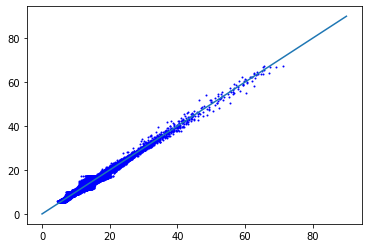

In [24]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = booster.booster_prediction(x_train)
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(49, 64, 64, 4)


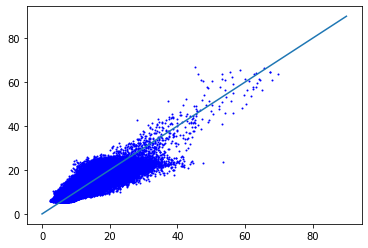

In [25]:
pred_test = booster.booster_prediction(x_test)
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: title={'center': 'true'}>

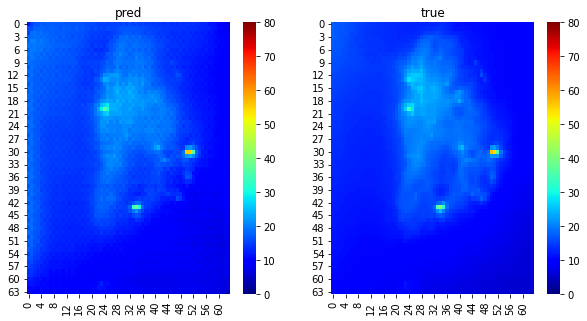

In [19]:
i = 0
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

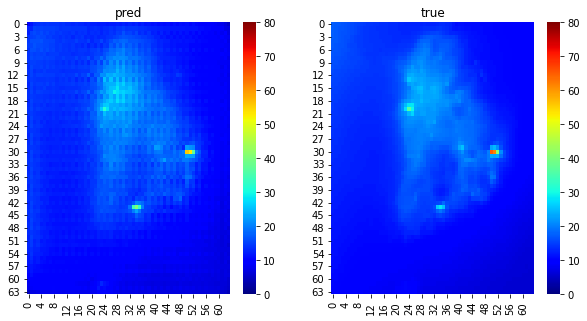

In [20]:
i = 1
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

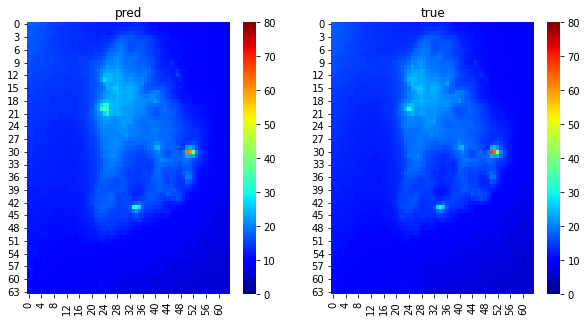

In [31]:
i = 2
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

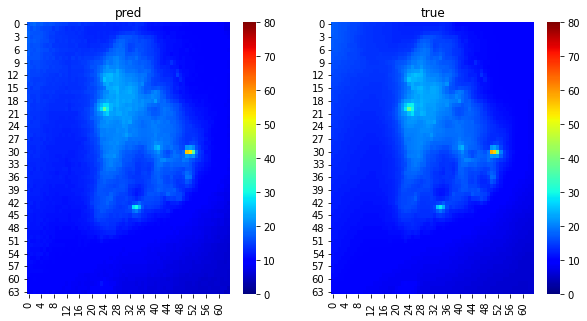

In [32]:
i = 3
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

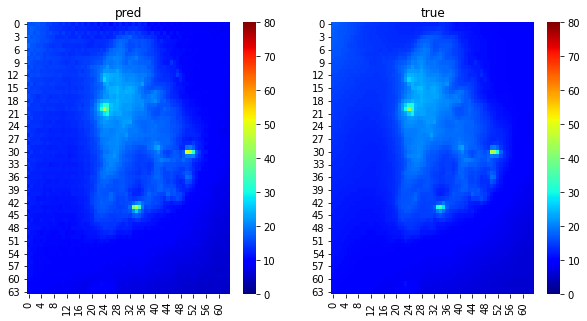

In [33]:
i = 4
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

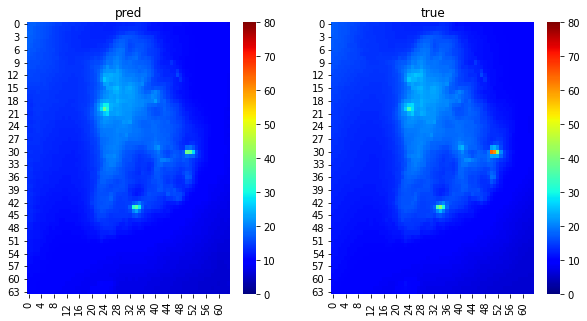

In [15]:
i = 5
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

<AxesSubplot: title={'center': 'true'}>

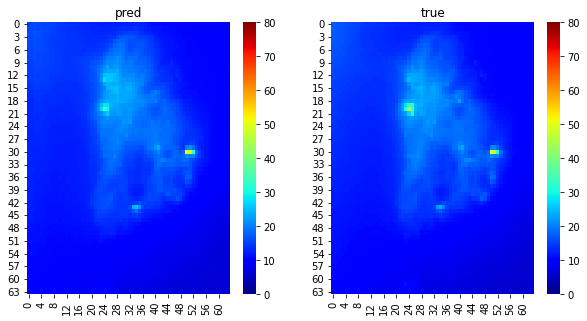

In [16]:
i = 6
fig = plt.figure(figsize = (10,5))
        
ax1_1 = fig.add_subplot(1,2,1)
ax1_1.title.set_text('pred')
sns.heatmap(pred[i][:,:,0][::-1], cmap = 'jet',ax = ax1_1,vmin=0, vmax=80)

ax1_2 = fig.add_subplot(1,2,2)
ax1_2.title.set_text('true')
sns.heatmap(pm2_5[i][:,:,0][::-1], cmap = 'jet',ax = ax1_2,vmin=0, vmax=80)

* Unet만 테스트

In [ ]:
# x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
# y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

# batch_size = 20
# epoch = 1000
# buffer_len = len(x_train_tensor)
# n_run = np.ceil(len(x_train_tensor)/batch_size)

# train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
# shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

In [8]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
# x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
# y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 10
epoch = 500
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

@tf.function()
def train_step(input, label, network, loss_fun,opt):

    with tf.GradientTape() as tape:
        ##로스 계산
        pred = network(input)
        
        loss = loss_fun(label, pred)
    grads = tape.gradient(loss, network.trainable_variables)
    opt.apply_gradients(zip(grads, network.trainable_variables))
    return loss

weak_net = Unet()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], weak_net,loss,optimizer).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")


batch: 1/7.0 ---epoch: 0/500--- mse-loss: 177.86215209960938
batch: 2/7.0 ---epoch: 0/500--- mse-loss: 174.35116577148438
batch: 3/7.0 ---epoch: 0/500--- mse-loss: 175.93270874023438
batch: 4/7.0 ---epoch: 0/500--- mse-loss: 177.16329956054688
batch: 5/7.0 ---epoch: 0/500--- mse-loss: 171.83302307128906
batch: 6/7.0 ---epoch: 0/500--- mse-loss: 177.46156311035156
batch: 7/7.0 ---epoch: 0/500--- mse-loss: 175.10409545898438
batch: 1/7.0 ---epoch: 1/500--- mse-loss: 171.3571014404297
batch: 2/7.0 ---epoch: 1/500--- mse-loss: 162.8998260498047
batch: 3/7.0 ---epoch: 1/500--- mse-loss: 150.03402709960938
batch: 4/7.0 ---epoch: 1/500--- mse-loss: 115.05802917480469
batch: 5/7.0 ---epoch: 1/500--- mse-loss: 55.920570373535156
batch: 6/7.0 ---epoch: 1/500--- mse-loss: 73.49918365478516
batch: 7/7.0 ---epoch: 1/500--- mse-loss: 31.52848243713379
batch: 1/7.0 ---epoch: 2/500--- mse-loss: 30.7724552154541
batch: 2/7.0 ---epoch: 2/500--- mse-loss: 42.210655212402344
batch: 3/7.0 ---epoch: 2/500--

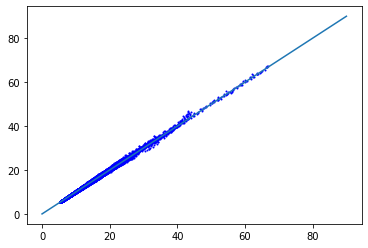

In [11]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = weak_net(x_train).numpy()
plt.plot(pred.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

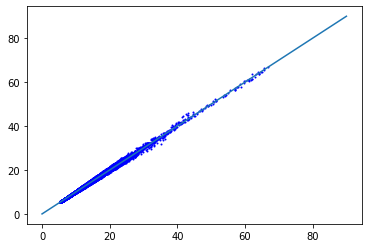

In [12]:
pred_test = weak_net(x_test).numpy()
plt.plot(pred_test.reshape(-1), pm2_5.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])